## Visualizing Results


Generating plots ...
  Saved -> xgboost_results_A.png


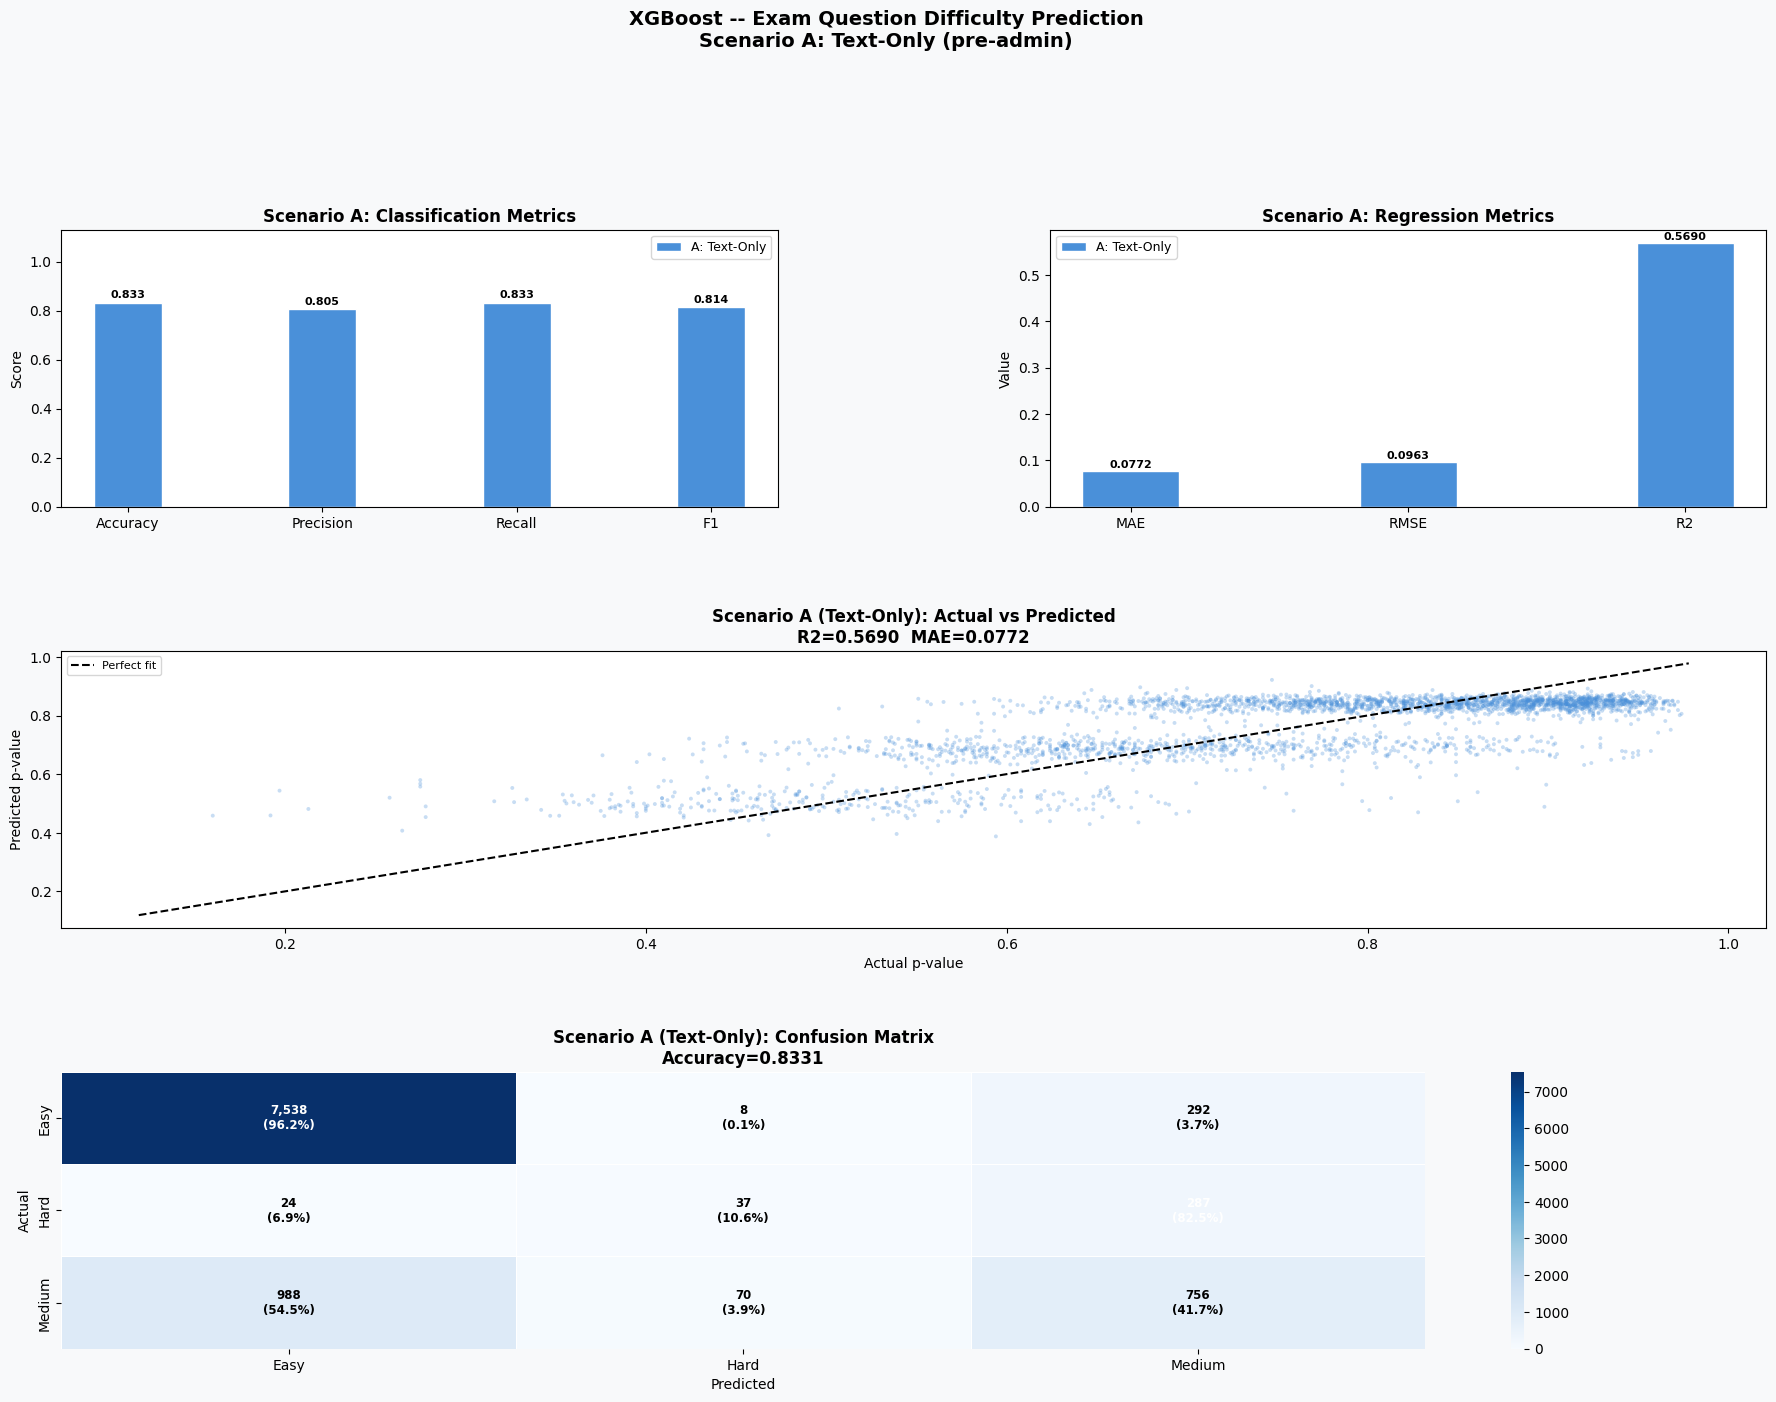

In [ ]:
print("\nGenerating plots ...")

fig = plt.figure(figsize=(22, 20))
fig.patch.set_facecolor("#F8F9FA")
fig.suptitle(
    "XGBoost -- Exam Question Difficulty Prediction\n: Text-Only (pre-admin)",
    fontsize=14, fontweight="bold", y=0.99
)

COL_A = "#4A90D9"
TOP   = 12

gs = fig.add_gridspec(4, 2, hspace=0.52, wspace=0.38) # Adjusted for single column where appropriate

# Row 0: metric comparison
ax = fig.add_subplot(gs[0, 0])
clf_metrics_list = ["Accuracy", "Precision", "Recall", "F1"]
a_vals = [results["A"]["Acc"], results["A"]["Prec"], results["A"]["Rec"], results["A"]["F1"]]
x = np.arange(len(clf_metrics_list)); w = 0.35
b1 = ax.bar(x, a_vals, w, color=COL_A, label="A: Text-Only",  edgecolor="white")
ax.set_xticks(x); ax.set_xticklabels(clf_metrics_list)
ax.set_ylim(0, 1.13); ax.set_ylabel("Score")
ax.set_title("Classification Metrics", fontweight="bold")
ax.legend(fontsize=9)
for bar in list(b1):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
            f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

ax = fig.add_subplot(gs[0, 1])
reg_m_names = ["MAE", "RMSE", "R2"]
ra_vals = [results["A"]["MAE"], results["A"]["RMSE"], results["A"]["R2"]]
x = np.arange(len(reg_m_names)); w = 0.35
b1 = ax.bar(x, ra_vals, w, color=COL_A, label="A: Text-Only",  edgecolor="white")
ax.set_xticks(x); ax.set_xticklabels(reg_m_names)
ax.set_ylabel("Value"); ax.set_title("Regression Metrics", fontweight="bold")
ax.legend(fontsize=9)
for bar in list(b1):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.002,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

# Row 1: Actual vs Predicted
ax = fig.add_subplot(gs[1, 0:2]) # Span across 2 columns
r = results["A"]
sample = np.random.choice(len(r["yr_te"]), 3000, replace=False)
ax.scatter(r["yr_te"].values[sample], r["reg_pred"][sample],
           alpha=0.3, s=8, color=COL_A, edgecolors="none")
mn, mx = r["yr_te"].min(), r["yr_te"].max()
ax.plot([mn, mx], [mn, mx], "k--", lw=1.5, label="Perfect fit")
ax.set_xlabel("Actual p-value"); ax.set_ylabel("Predicted p-value")
ax.set_title(f"Actual vs Predicted\nR2={r['R2']:.4f}  MAE={r['MAE']:.4f}", fontweight="bold")
ax.legend(fontsize=8)

# Row 2: Confusion matrices
ax = fig.add_subplot(gs[2, 0:2]) # Span across 2 columns
r = results["A"]
cm = confusion_matrix(r["yc_te"], r["clf_pred"])
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax, linewidths=0.5, vmin=0, vmax=cm.max())
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j+0.5, i+0.5, f"{cm[i,j]:,}\n({cm_pct[i,j]:.1f}%)",
                ha="center", va="center", fontsize=8.5, fontweight="bold",
                color="white" if cm_pct[i,j] > 55 else "black")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title(f"Confusion Matrix\nAccuracy={r['Acc']:.4f}", fontweight="bold")

plt.savefig("xgboost_results_A.png", dpi=180, bbox_inches="tight", facecolor="#F8F9FA")
print("  Saved -> xgboost_results_A.png")

In [ ]:
import os

# Remove results['B'] from the dictionary if it exists
if 'B' in results:
    del results['B']
    print("Deleted results['B'] from memory.")

# List of files to delete
files_to_delete = [
    '/content/xgboost_predictions_B.csv',
    '/content/xgb_clf_model_B.json',
    '/content/xgb_reg_model_B.json',
    '/content/xgboost_results.png' # Original composite plot
]

for f in files_to_delete:
    if os.path.exists(f):
        os.remove(f)
        print(f"Deleted file: {f}")
    else:
        print(f"File not found (already deleted or never created): {f}")

# Remove Xb, Xb_tr, Xb_te, ybr_tr, ybr_te, ybc_tr, ybc_te from global scope if they exist
for var_name in ['Xb', 'Xb_tr', 'Xb_te', 'ybr_tr', 'ybr_te', 'ybc_tr', 'ybc_te',
                'b_acc', 'b_f1', 'b_mae', 'b_prec', 'b_r2', 'b_rec', 'b_rmse', 'b_vals']:
    if var_name in globals():
        del globals()[var_name]
        print(f"Deleted variable: {var_name}")


In [ ]:
# Save predictions to CSV files
for key, Xte, xr, xc, yr, yc in [
    ("A", Xa_te, a_reg_pred, a_clf_pred, yar_te, yac_te),
]:
    pd.DataFrame({
        "QuestionId":       df.loc[Xte.index, "QuestionId"].values,
        "SubjectName":      df.loc[Xte.index, "SubjectName"].values,
        "actual_p_value":   yr.values.round(4),
        "xgb_pred_p_value": xr.round(4),
        "actual_label":     le.inverse_transform(yc),
        "xgb_pred_label":   le.inverse_transform(xc),
        "correct":          (xc == yc).astype(int),
    }).to_csv(f"xgboost_predictions_{key}.csv", index=False)
    print(f"  Saved -> xgboost_predictions_{key}.csv")

In [ ]:
print("\n" + "="*55)
print("FINAL SUMMARY")
print("="*55)
print(f"{'Metric':<22} {'Scenario':>14}")
print("-"*36)
print(f"{'Feature count':<22} {results['A']['n_feat']:>14}")
print("-"*36)
print("[Regression]")
print(f"  {'MAE':<20} {results['A']['MAE']:>14.4f}")
print(f"  {'RMSE':<20} {results['A']['RMSE']:>14.4f}")
print(f"  {'R2':<20} {results['A']['R2']:>14.4f}")
print("[Classification]")
print(f"  {'Accuracy':<20} {results['A']['Acc']:>14.4f}")
print(f"  {'F1 (weighted)':<20} {results['A']['F1']:>14.4f}")
print(f"  {'CV Acc (5-fold)':<20} {results['A']['CV']:.4f}+/-{results['A']['CV_std']:.4f}")

In [ ]:
import joblib

a_reg.save_model('xgb_reg_model_A.json')
a_clf.save_model('xgb_clf_model_A.json')

# Save the label encoder too
joblib.dump(le, 'pipeline.pkl')

# Download the files
from google.colab import files
files.download('xgb_reg_model_A.json')
files.download('xgb_clf_model_A.json')
files.download('pipeline.pkl')